# GEO877: Spatial Algorithms - Haklay - Preprocessing



## Introduction

In Haklay paper, a comparison has been made between OSM dataset and official datasets from the UK. To reproduce it for Switzerland, we have decided to compare OSM with ASTRA.

In [1]:
# Basic geomtries from GEO877
from geospatial import *

# Plotting, Arrays and Filepath handling
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Transformation function based on pyproj Transformer
from pyproj import Transformer

# OSM Part
import geopandas as gpd

# ASTRA Part
import fiona

# Writing to Pickle
import pickle

def write_to_pickle(variable, filename):
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)

def read_from_pickle(filename):
    with open(filename, 'rb') as f:
        variable = pickle.load(f)
    return variable

#Stitching together code snippets
import nbimporter

plot_steps = False
pickle_processe = True

## Classes and functions

In [2]:
# Define class to store attributes with each motorway segment
class MotorwaySegment(Segment):
    def __init__(self, start, end, name=str(), origin_name=str(), source=str(), crs=str()):
        super().__init__(start, end)
        self.name = name
        self.origin_name = origin_name
        self.source = source
        self.crs = crs
    
    # Overwrite representation
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}.' 
    
    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        xs = [self.start.x, self.end.x]
        ys = [self.start.y, self.end.y]
        if ax:
            ax.plot(xs, ys, color = color, linewidth = linewidth, label=label)
        else:
            plt.plot(xs, ys, color = color, linewidth = linewidth, label=label)



In [3]:
def name_mapping(in_name):
    #special cases, checked on QGIS:
    name_map = {"32": 1,
            "A1;A4": 1,
            "A1;A2": 1,
            "A1;A3": 1,
            "A1;A6": 1,
            "A1;A9": 1,
            "A9;A 2": 2,
            "A2;A3": 2,
            "A3;A4": 3,
            "53": 15,
            "A20;20": 20
           }
    if in_name in name_map.keys():
        return name_map[in_name]

    #correct cases:
    if ";" not in in_name:
        return int(''.join(filter(str.isdigit, in_name)))
    
    #catch new roads names
    else:
        print(in_name)
        print("Name not treated")

In [4]:
def linestring_to_motorwaysegment_list(ls_seg):
    name = ls_seg["name"]
    name_origin = ls_seg["ref"]
    source = ls_seg["source"]
    crs = ls_seg["crs"]
    point_list = tuple(Point(x,y) for x,y in zip(*ls_seg.geometry.coords.xy))
    if len(point_list) <=1:
        print("Cannot build MotorwaySegment from line with less than 2 points!")
        return
    else:
        segment_list = [MotorwaySegment(start, end, name, name_origin, source, crs) for start,end in zip(point_list[:-1],point_list[1:])]
        return segment_list

In [5]:
def transform_segment(segment, transformer, to_crs):
    start = segment.start
    end = segment.end
    name = segment.name
    source = segment.source
    crs = segment.crs
    start_transformed = transformer.transform(start.y, start.x)
    end_transformed = transformer.transform(end.y, end.x)
    transformed_segment = MotorwaySegment(Point(*start_transformed), Point(*end_transformed), name, source, to_crs)
    return transformed_segment

In [6]:
class MotorwayLine():
    #initialise
    def __init__(self, data=None, xcol=None, ycol=None): #data = list of segments from the same street
        self.segments = []
        self.name = data[0].name
        self.points = []
        self.points_x = [] #to test
        self.points_y = [] #to test
        
        for d in data:
            #add segment
            self.segments.append(d)
            #add points - there will be duplicates /!\
            self.points.append(d.start)
            self.points.append(d.end)
            self.points_x.append(d.start.x)
            self.points_x.append(d.end.x)
            self.points_y.append(d.start.y)
            self.points_y.append(d.end.y)  
    
    def __len__(self):
        return len(self.segments)
    
        # Test for equality between Segments - we treat segments going in opposite directions as equal here
    def __eq__(self, other): 
        if (self.points_x == other.points_x or self.points_x[::-1] == other.points_x) and (self.points_y == other.points_y or self.points_y[::-1] == other.points_y) :
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries
    
    def __hash__(self):
        return hash((self.segments, self.points_x, self.points_y)) 
    
    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        n = len(self.points)
        print(f'The old line had {oldn} points, now we only have {n}.')
        return self
        
    def bbox(self):
        x = [i.x for i in self.points]   # extract all x coords as a list
        y = [i.y for i in self.points]   # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))    # lower-left corner (min x, min y)
        self.ur = Point(max(x), max(y))    # upper-right corner (max x, max y)
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)   # centre of box
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    # area of box
        print(f'Bounding box with lower-left {self.ll} and upper-right {self.ur}' )
        return self.ll, self.ur
    
    def plot_bbox(self):
        ll, ur = self.bbox()
        plt.plot([ll.x, ll.x, ur.x, ur.x, ll.x], [ll.y, ur.y, ur.y, ll.y, ll.y], linestyle='dashed')

    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        for seg in self.segments:
            seg.plot_seg(ax = ax, color = color, linewidth = linewidth, label = label)
    
    def plot_seg2(self):
        xs = []
        ys = []
        for seg in self.segments:
            xs.append(seg.start.x)
            xs.append(seg.end.x)
            ys.append(seg.start.y)
            ys.append(seg.end.y)

        plt.plot(xs, ys)
        
        
     # Overwrite representation
    def __repr__(self):
        return f'MotorwayLine "{self.name}" has "{len(self.segments)}" segments, and "{len(self.points)}" points.'    


## OSM

### Download data

In [ ]:
# Define Filepath and OSM tags
tags = {"highway":"motorway"}
motorway_file_path = Path(r"./data/motorways_osm.geojson")

# Download OSM Data to GeoDataFrame() if GeoJSON does not exist
if motorway_file_path.is_file():
    motorways = gpd.read_file(motorway_file_path)
else:
    # Needs special requirements for shapely, geopandas and other packages /!\
    # Use ox package to download geometries from
    import osmnx as ox
    motorways = ox.geometries_from_place("Switzerland",tags=tags)
    # Convert lists to strings for GeoJSON
    motorways = motorways.apply(lambda col: col.astype(str) if isinstance(col[0], list) else col)
    motorways.to_file(motorway_file_path, "GeoJSON")

if plot_steps:
    motorways.plot()

### Data filtering
To have the same data as in ASTRA, some filter has to be applied.

Some highways collected in OSM are not taken care by ASTRA, but by cantons. They are therefore not in ASTRA datasets and were discarded ("A50" and "A51").
Subsections of the highway "A1" ("A1a", "A1H", "A1R", "A1L", "A3W"), are not represented in the ASTRA data, and were therefore discarded.  
"A24" was also discarded as it is a road feeder and was normally not represented in OSM like the other road feeders.


In [ ]:
## TODO Maybe note how many segments are being removed?
#Remove unwanted segments and remove NA
discard_list = ["A1a", "A1H", "A1R","A1R;5", "A1L", "A3W", "A24", "A50", "7;A50", "A51"]
filter_osm = ~motorways.ref.isin(discard_list)
motorways = motorways[filter_osm]
motorways = motorways[motorways['ref'].notna()]


### Convert LineString() to list of MotorwaySegment()

In [ ]:
mway = motorways.copy()
mway["geometry"] = mway.geometry.explode(index_parts=False)
mway["source"] = "osm"
mway["crs"] = 'epsg:4326'
mway["name"] = mway['ref'].apply(name_mapping)

mway["segments"] = mway.apply(linestring_to_motorwaysegment_list, axis=1)
mway = mway.explode("segments", index_parts=False)
mway = mway.reset_index()

### Transform from EPSG:4326 to EPSG:2056

In [ ]:
# Example 4326 to 2056
from_crs = 'epsg:4326'
to_crs = 'epsg:2056'

transformer = Transformer.from_crs(from_crs, to_crs)
motorway_segments_transformed = mway["segments"].apply(transform_segment, transformer=transformer, to_crs=to_crs)
if plot_steps:
    print(f"{mway['segments'][0]} {mway['segments'][0].crs}",
          f"{motorway_segments_transformed[0]} \t {motorway_segments_transformed[0].crs}",
          sep="\n")

### Roads renaming
As OSM data is not rigorious, some corrections had to be made on the name registered. Visual data inspection was required for some cryptic names ("32", "52", "nan", ...). Then, only the number of the road has been kept.  
Example of corrections: "A 12" -> "A12", "A10;7" -> "A10", "53" -> "A15".


In [ ]:
if plot_steps:
    streetnames_osm_toclean = motorways.ref.unique()

    print(streetnames_osm_toclean)
    print(len(streetnames_osm_toclean))

    # Test/showcase only (not needed in main script)
    #build streetnames_osm list
    streetnames_osm = list(set(name_mapping(street) for street in streetnames_osm_toclean))

    print(sorted(streetnames_osm))
    print(len(streetnames_osm))

### Class MotorwayLine

In [ ]:
# Create Lookup dictionary with Segments by segment name (1:[MotorwaysSegment,...],2:[],...)
segments_by_name = {}
for segment in motorway_segments_transformed:
    if segment.name not in segments_by_name:
        segments_by_name[segment.name] = []
    segments_by_name[segment.name].append(segment)

streetnames_osm = motorway_segments_transformed.apply(lambda x: x.name).unique()
motorway_osm_lines = []
for streetname in streetnames_osm:
    # Use streetname to retrieve list of segments
    list_segments = segments_by_name.get(streetname, [])
    if list_segments:
        motorwayLine = MotorwayLine(list_segments)
        motorway_osm_lines.append(motorwayLine)

motorway_osm_lines = sorted(motorway_osm_lines, key=lambda x: x.name)

if plot_steps:
    print(motorway_osm_lines[0])
    print(motorway_osm_lines[0].segments[0].origin_name)
    len(motorway_osm_lines)

### Data exploration

In [ ]:
if plot_steps:
    motorway_osm_lines[0].segments[0:10]

In [ ]:
if plot_steps:
    # PLOT FROM ORIGINAL GEOMETRY
    print(len(motorways[motorways["ref"]=="A2"]))
    motorways[motorways["ref"]=="A2"].plot()

In [ ]:
if plot_steps:
    # PLOT A1
    print(motorway_osm_lines[1])
    motorway_osm_lines[1].removeDuplicates()
    motorway_osm_lines[1].plot_bbox()
    motorway_osm_lines[1].plot_seg()

## Swissdataset: Astra national roads

### Download data
Download data from:  
https://data.geo.admin.ch/browser/index.html#/collections/ch.astra.nationalstrassenachsen/items/nationalstrassenachsen?.language=en&.asset=asset-nationalstrassenachsen_2056.gdb.zip 


In [ ]:
#import .gdb
fiona.listlayers(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"))
motorways_ch = gpd.read_file(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"), driver='FileGDB', layer='Stammachsen')
if plot_steps:
    motorways_ch.plot()

In [ ]:
if plot_steps:
    #visualize first 3 rows
    motorways_ch[0:3]

### Data filtering
The federal roads office ASTRA [[1]](https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html) is responsible for the national roads, i.e. the most important roads for Switzerland. Therefore ASTRA datasets do not only include highways, but also main roads.   
To sort national roads, a visual inspection of both datasets (OSM and ASTRA) was made on QGIS. This helped discovering that one of the attributes in ASTRA dataset could be used as a filter:
- Positionscode "=".  
"=" indicates that this is a one way road, which correlates with not being a highway, therefore not present in OSM dataset with the tag "highway".  
8 national roads were removed entirely this way (N1BAR, N2BEL, N2P, N17, N24, N25, N28 and N29).
Excepted for N24 (feeder road), which was removed even though it was also on OSM, this proved to be an efficient and quick filter.  
Out of 28 national roads, 20 then remained.

In addition, to crossvalidate the results, the following ressources have been used:  
- [autobahnen.ch](https://www.autobahnen.ch/).
- [Wiki page: List of the swiss national roads](https://de.wikipedia.org/wiki/Liste_der_Nationalstrassen_der_Schweiz)
- [Wiki page: List of the swiss highways and motorroads](https://de.wikipedia.org/wiki/Liste_der_Autobahnen_und_Autostrassen_in_der_Schweiz)

Astra dataset is unfortunately poorly documented online, therefore wikipedia was a useful source.

[[1]]: https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html

### Renaming of the roads
National roads numbers (N1 -> N...) correspond with highways numbers (A1 -> A...), therefore the renaming contained only the number.

In [ ]:
# Remove positionscode
filt_equal = motorways_ch["Positionscode"] != "="
motorways_ch = motorways_ch.copy().loc[filt_equal]

In [ ]:
# Extract streetname and convert to int
motorways_ch.loc[:, 'streetname'] = motorways_ch['Strassennummer'].str.extract(r'(\d+)').astype(int)

streetnames_ch = motorways_ch['streetname'].unique()
if plot_steps:
    print(sorted(streetnames_ch))
    print(len(streetnames_ch))

### Class MotorwaySegment

In [ ]:
mway_ch = motorways_ch.copy()
mway_ch["geometry"] = mway_ch.geometry.explode(index_parts=False)
mway_ch["source"] = "astra"
mway_ch["crs"] = 'epsg:2056'
mway_ch["name"] = mway_ch['streetname']
mway_ch["ref"] = mway_ch["Strassennummer"]

mway_ch['segments'] = mway_ch.apply(linestring_to_motorwaysegment_list, axis=1)
mway_ch = mway_ch.explode("segments", index_parts=False)
mway_ch = mway_ch.reset_index()

### Class MotorwayLine

In [ ]:
segments_by_name = {}
for segment in mway_ch['segments']:
    if segment.name not in segments_by_name:
        segments_by_name[segment.name] = []
    segments_by_name[segment.name].append(segment)

motorway_ch_lines = []
for streetname in streetnames_ch:
    list_segments = segments_by_name.get(streetname,[])
    if list_segments:
        motorwayLine = MotorwayLine(list_segments)
        motorway_ch_lines.append(motorwayLine)

motorway_ch_lines = sorted(motorway_ch_lines, key=lambda x: x.name)

if plot_steps:
    print(motorway_ch_lines[1])
    print(motorway_ch_lines[1].segments[1].origin_name)
    len(motorway_ch_lines)

# Write MotorwayLine to Pickle

In [ ]:
# TODO
# motorway_ch_lines to Pickle
write_to_pickle(motorway_osm_lines, "motorway_osm_lines.pkl")
write_to_pickle(motorway_ch_lines, "motorway_ch_lines.pkl")

### Data exploration

In [ ]:
for motorway in motorway_ch_lines:
    if motorway.name == 2:
        N2 = motorway

if plot_steps:
    N2.segments[0:10]

In [ ]:
if plot_steps:
    # PLOT A2 FROM ORIGINAL GEOMETRY
    print(len(motorways_ch[motorways_ch["Strassennummer"] == "N2"]))
    motorways_ch[motorways_ch["Strassennummer"] == "N2"].plot()

In [ ]:
if plot_steps:
    # PLOT A2 FROM MOTORWAY LINES
    print(N2)
    N2.removeDuplicates()
    N2.plot_bbox()
    N2.plot_seg()

## Datasets comparison

In [ ]:
if plot_steps:
    print(sorted(streetnames_osm))
    print(sorted(streetnames_ch))
    print(len(streetnames_osm))

### Comparison of the motorway lines

In [ ]:
if plot_steps:
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    for i in range(5): #5
        for j in range(4): #4
            index = i * 4 + j
            motorway_ch_lines[index].plot_seg(ax = axs[i, j], label="ASTRA", color = "blue", linewidth = 5)
            motorway_osm_lines[index].plot_seg(ax = axs[i, j], label="OSM", color = "red")
            axs[i, j].set_title(f'A{motorway_osm_lines[index].name}')
            axs[i,j].set_aspect('equal', adjustable='datalim')

    # Affichage de la figure
    plt.tight_layout()
    plt.show()
    #fig.savefig("plots/osm_astra_comparison.png")

# Buffering MotorwayLines

In [7]:
from Buffer import buffer

In [8]:
astra = read_from_pickle("motorway_ch_lines.pkl")
osm = read_from_pickle("motorway_osm_lines.pkl")

list_unique_points_astra = [mw_line.removeDuplicates().points for mw_line in astra]
#buffered_astra = buffer(nodes=list_unique_points_astra[0], dist=10, nn=20, reduction=50)
buffered_astra = list(map(lambda points: buffer(nodes=points, dist=10, nn=3, reduction=50), list_unique_points_astra[:2]))
write_to_pickle(buffered_astra, "buffered_astra.pkl")

The old line had 45496 points, now we only have 22763.
The old line had 34792 points, now we only have 17086.
The old line had 18960 points, now we only have 9491.
The old line had 11396 points, now we only have 5703.
The old line had 15624 points, now we only have 7816.
The old line had 9316 points, now we only have 4664.
The old line had 3756 points, now we only have 1880.
The old line had 2864 points, now we only have 1435.
The old line had 19960 points, now we only have 9983.
The old line had 902 points, now we only have 453.
The old line had 9756 points, now we only have 4880.
The old line had 14926 points, now we only have 7477.
The old line had 3810 points, now we only have 1909.
The old line had 2834 points, now we only have 1419.
The old line had 11548 points, now we only have 5776.
The old line had 1070 points, now we only have 537.
The old line had 9978 points, now we only have 4993.
The old line had 432 points, now we only have 217.
The old line had 2414 points, now we only

In [9]:
list_unique_points_osm = [mw_line.removeDuplicates().points for mw_line in osm]
buffered_osm = list(map(lambda points: buffer(nodes=points, dist=10, nn=3, reduction=50), list_unique_points_osm[:2]))
write_to_pickle(buffered_osm, "buffered_osm.pkl")

The old line had 34556 points, now we only have 17284.
The old line had 18096 points, now we only have 9055.
The old line had 8504 points, now we only have 4261.
The old line had 3450 points, now we only have 1731.
The old line had 4716 points, now we only have 2361.
The old line had 7360 points, now we only have 3688.
The old line had 1412 points, now we only have 706.
The old line had 726 points, now we only have 367.
The old line had 8984 points, now we only have 4500.
The old line had 518 points, now we only have 261.
The old line had 8126 points, now we only have 4065.
The old line had 4956 points, now we only have 2486.
The old line had 1410 points, now we only have 709.
The old line had 1892 points, now we only have 951.
The old line had 3382 points, now we only have 1698.
The old line had 430 points, now we only have 217.
The old line had 1010 points, now we only have 508.
The old line had 128 points, now we only have 66.
The old line had 792 points, now we only have 401.
The o

In [ ]:
import cProfile
import pstats

def my_function():
    buffer(nodes=list_unique_points_astra[0], dist=10, nn=20, reduction=50)

profile = cProfile.Profile()
profile.runcall(my_function)
ps = pstats.Stats(profile)
ps.print_stats()

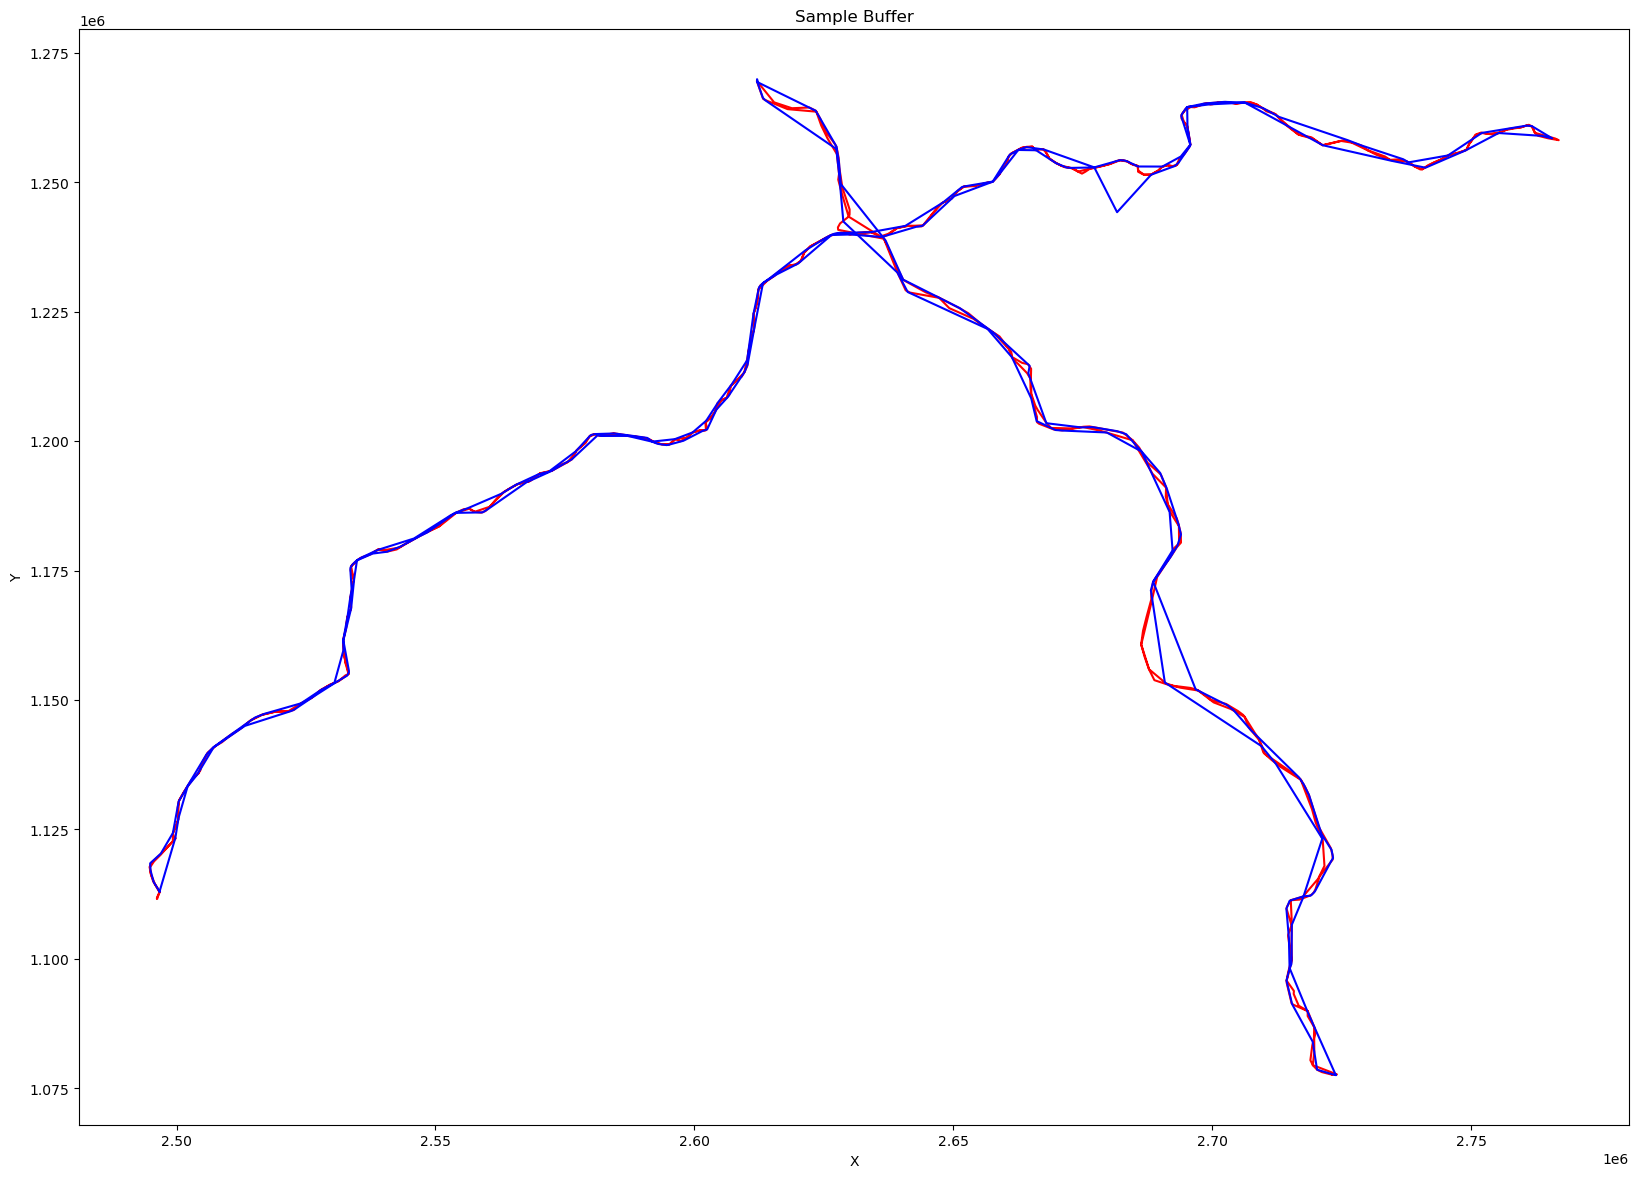

In [37]:
fig, ax0 = plt.subplots(figsize = (20,20))

buffered_astra_segments = [[p1,p2] for p1,p2 in zip(buffered_astra[0], buffered_astra[1])]
buffered_osm_segments = [[p1,p2] for p1,p2 in zip(buffered_osm[0], buffered_osm[1])]


for polygon in buffered_astra:
    ax0.plot([p.x for p in polygon.points],
             [p.y for p in polygon.points], color = 'red')

for polygon in buffered_osm:
    ax0.plot([p.x for p in polygon.points],
             [p.y for p in polygon.points], color = 'blue')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Sample Buffer')
ax0.set_aspect('equal')

# Intersection Buffer Geometries

In [8]:
from Segment_Polygon_Intersection_AlgorithmsOnly_updated import *

In [14]:
# Load points in array([[]])
lines_astra = read_from_pickle("motorway_ch_lines.pkl")
lines_osm = read_from_pickle("motorway_osm_lines.pkl")
buffered_astra = read_from_pickle("buffered_astra.pkl")
buffered_osm = read_from_pickle("buffered_osm.pkl")


In [ ]:
osm_segs = [seg for seg in chain(*[mw_line.segments for mw_line in lines_osm[:2]])]

In [ ]:
inter = inter_multi_seg_pol(seg_g=osm_segs, pol_g=buffered_astra)
inter/sum([seg.length for seg in osm_segs])

# Similarity Measure

In [7]:
from Similarity_Measures import dtw